# Exercise 2 - Group 4
- Matthias Egli
- Florian Bär
- Manuel Vogel
- Adrian Willi

In [14]:
# First, import TF and get its version.
import tensorflow as tf
from tensorflow import keras
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


In [15]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix

%matplotlib inline


## Loading the raw data

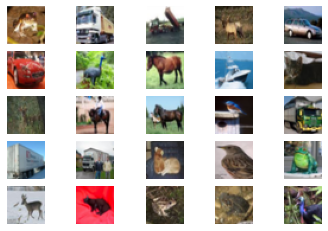

In [16]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,5):
        for j in range(0,5):
            plt.subplot2grid((5,5),(i,j))
            plt.imshow(X[k], cmap='gray')
            k = k+1
            plt.axis('off')
    # show the plot
    plt.show()
    
# Load data & split data between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

show_imgs(X_train)

In [17]:
# check shape and type
print(X_train.shape)
print(X_train.dtype)
print(y_train.shape)

(50000, 32, 32, 3)
uint8
(50000, 1)


In [18]:
# reshape inputs
X_train = X_train.reshape(50000, 3072)
X_test = X_test.reshape(10000, 3072)

# Normalize input
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [19]:
# number of classes
n_classes = 10

# Conversion to class vectors
Y_train = keras.utils.to_categorical(y_train, n_classes)
Y_test = keras.utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## One-layer network and weight visualisation
### Define the network

In [7]:
E = 5                # number of epochs
B = 128              # batch size
D = X_train.shape[1] # dimension of input sample - 3072 for CIFAR10

regularizer = tf.keras.regularizers.l2(0.05)

# one layer network
model = keras.models.Sequential()
model.add(keras.layers.Dense(n_classes, input_shape=(D,), activation='softmax', kernel_regularizer=regularizer))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30730     
                                                                 
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


### Compile and train the network
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, 
                Y_train, 
                batch_size=B, 
                epochs=E,
                verbose=1, 
                validation_data=(X_test, Y_test))

Epoch 1/5
391/391 [==============================] - 5s 9ms/step - loss: 2.2939 - accuracy: 0.3043 - val_loss: 1.9673 - val_accuracy: 0.3589
Epoch 2/5
391/391 [==============================] - 4s 10ms/step - loss: 1.9876 - accuracy: 0.3347 - val_loss: 1.9959 - val_accuracy: 0.3168
Epoch 3/5
391/391 [==============================] - 4s 9ms/step - loss: 1.9862 - accuracy: 0.3296 - val_loss: 2.0092 - val_accuracy: 0.3097
Epoch 4/5
391/391 [==============================] - 2s 6ms/step - loss: 1.9874 - accuracy: 0.3282 - val_loss: 1.9987 - val_accuracy: 0.3313
Epoch 5/5
391/391 [==============================] - 3s 6ms/step - loss: 1.9894 - accuracy: 0.3284 - val_loss: 2.0557 - val_accuracy: 0.3072


### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

(3072, 10)
(10,)


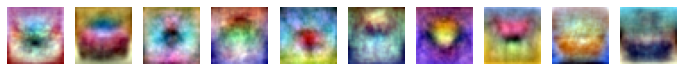

In [9]:
weights = model.get_weights()
for w in weights:
    print(w.shape)
w1 = weights[0]
f = plt.figure(figsize=(12,12))
for i in range(10):
    ax = f.add_subplot(1, 10, 1+i)
    im = w1[:,i]                  # get the weights landing to neuron i
    im = im.reshape(32, 32, 3)
    # now put back the pixel values to 0-256 doing a min-max norm and multiplying by 256
    min = np.min(im, axis=0).min(axis=0)
    max = np.max(im, axis=0).max(axis=0)
    im = np.round((im - min)/(max - min) * 255).astype(int)
    ax.axis('off')
    ax.imshow(im)

## Two-layer network
### Define the network 

In [10]:
E = 30                # number of epochs
B = 128              # batch size
D = X_train.shape[1] # dimension of input sample - 3072 for CIFAR10

# one layer network
H = 128
model = keras.models.Sequential()
model.add(Dense(H, input_shape=(D,), activation='relu'))
model.add(keras.layers.Dense(n_classes, input_shape=(D,), activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               393344    
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = model.fit(X_train, 
                Y_train, 
                batch_size=B, 
                epochs=E,
                verbose=1, 
                validation_data=(X_test, Y_test))

Epoch 1/30
391/391 [==============================] - 5s 11ms/step - loss: 1.9313 - accuracy: 0.3142 - val_loss: 1.7970 - val_accuracy: 0.3553
Epoch 2/30
391/391 [==============================] - 4s 10ms/step - loss: 1.7827 - accuracy: 0.3720 - val_loss: 1.7386 - val_accuracy: 0.3811
Epoch 3/30
391/391 [==============================] - 4s 10ms/step - loss: 1.7045 - accuracy: 0.3995 - val_loss: 1.7069 - val_accuracy: 0.3918
Epoch 4/30
391/391 [==============================] - 4s 11ms/step - loss: 1.6667 - accuracy: 0.4096 - val_loss: 1.6822 - val_accuracy: 0.3999
Epoch 5/30
391/391 [==============================] - 4s 9ms/step - loss: 1.6365 - accuracy: 0.4202 - val_loss: 1.6868 - val_accuracy: 0.3974
Epoch 6/30
391/391 [==============================] - 5s 13ms/step - loss: 1.6114 - accuracy: 0.4290 - val_loss: 1.6054 - val_accuracy: 0.4327
Epoch 7/30
391/391 [==============================] - 5s 12ms/step - loss: 1.5964 - accuracy: 0.4339 - val_loss: 1.6012 - val_accuracy: 0.4311


### Evaluate the network

#### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

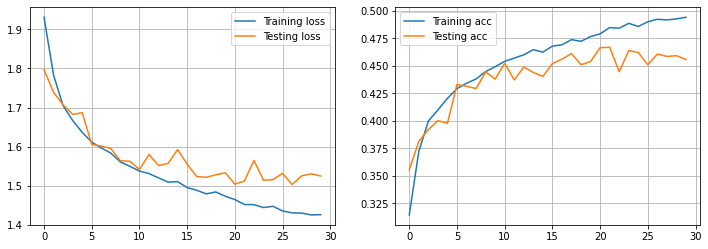

In [13]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

#### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [14]:
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 1.5243301391601562
Test accuracy: 0.4555000066757202


## Hyperparameter search using sklearn

In [22]:

# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Function to create model, required for KerasClassifier

D = X_train.shape[1:]
n_classes = 10

def create_model(n_neurons:list=[128]):
    # create model
    model = Sequential()
    for neuron in n_neurons:
        model.add(Dense(neuron, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
  
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [128]
epochs = [30]
n_neurons = [(128), (256, 128), (512, 256, 128)]

param_grid = dict(batch_size=batch_size, epochs=epochs, n_neurons=n_neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=3)
grid_result = grid.fit(X_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

C:\Users\adria\AppData\Local\Temp\ipykernel_17848\1446263932.py:28: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


C:\Users\adria\OneDrive\Dokumente\Studium - Hslu\Master\TSM_DeLearn\venv\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\adria\OneDrive\Dokumente\Studium - Hslu\Master\TSM_DeLearn\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\adria\OneDrive\Dokumente\Studium - Hslu\Master\TSM_DeLearn\venv\lib\site-packages\keras\wrappers\scikit_learn.py", line 236, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "

Best: 0.496680 using {'batch_size': 128, 'epochs': 30, 'n_neurons': (512, 256, 128)}
nan (nan) with: {'batch_size': 128, 'epochs': 30, 'n_neurons': 128}
0.494520 (0.006832) with: {'batch_size': 128, 'epochs': 30, 'n_neurons': (256, 128)}
0.496680 (0.005936) with: {'batch_size': 128, 'epochs': 30, 'n_neurons': (512, 256, 128)}


In [23]:
print(grid.best_params_)
print(grid.best_estimator_.score(X_test, Y_test))

{'batch_size': 128, 'epochs': 30, 'n_neurons': (512, 256, 128)}
0.5162000060081482
